Using device: cuda


Training Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0, Total Reward: 249.93262025812635, Path Length: 300
Episode 100, Total Reward: 382.0991693848456, Path Length: 300
Episode 200, Total Reward: 649.1812087098393, Path Length: 233
Episode 300, Total Reward: 649.1812087098393, Path Length: 232
Episode 400, Total Reward: 649.1812087098393, Path Length: 230
Episode 500, Total Reward: 649.181208709839, Path Length: 237
Episode 600, Total Reward: 649.181208709839, Path Length: 267
Episode 700, Total Reward: 649.1812087098393, Path Length: 232
Episode 800, Total Reward: 444.7090727548401, Path Length: 300
Episode 900, Total Reward: 444.7090727548399, Path Length: 300


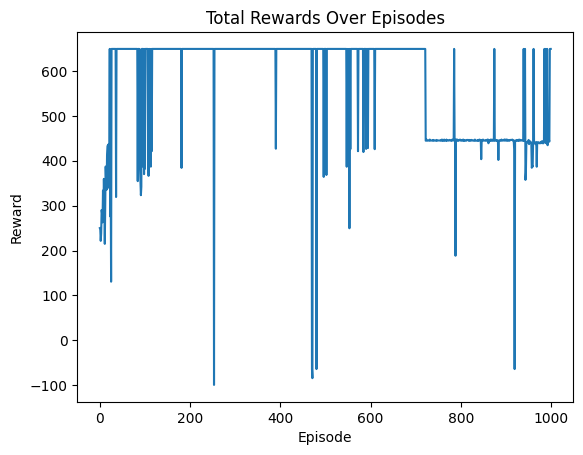

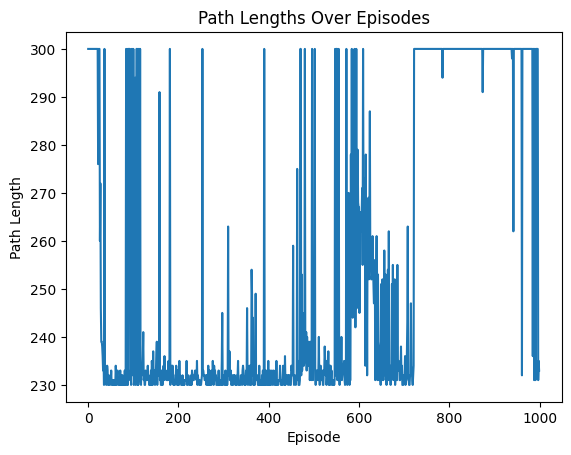

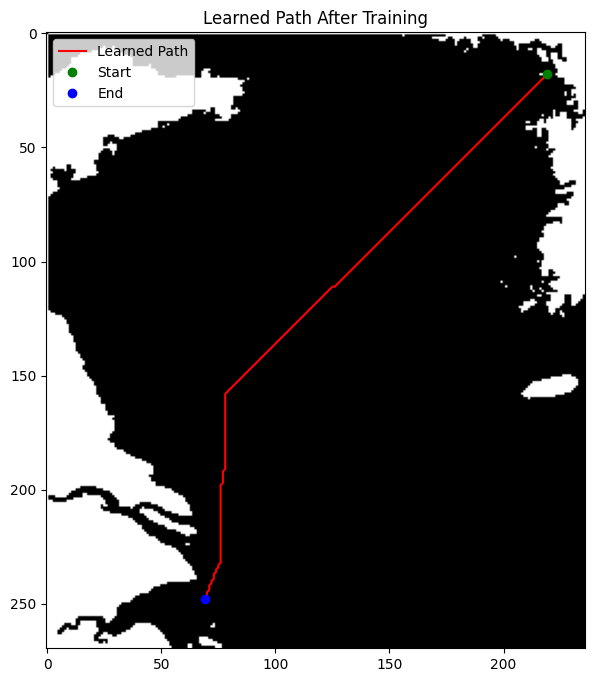

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.value_stream = nn.Linear(64, 1)
        self.advantage_stream = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write = (self.write + 1) % self.capacity
        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        while idx != 0:
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get(self, s):
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                break
            if s <= self.tree[left]:
                idx = left
            else:
                s -= self.tree[left]
                idx = right
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]

    def total(self):
        return self.tree[0]

class NavigationEnv:
    def __init__(self):
        self.grid = np.load('land_sea_grid_cartopy_downsized.npy')
        self.n_rows, self.n_cols = self.grid.shape
        self.lat_min, self.lat_max = 30.0, 38.0
        self.lon_min, self.lon_max = 120.0, 127.0
        self.start_pos = self.latlon_to_grid(37.46036, 126.52360)
        self.end_pos = self.latlon_to_grid(30.62828, 122.06400)
        self.max_steps = 300
        self.step_count = 0
        # 액션 공간은 5방향으로 유지
        self.action_space = np.array([-90, -45, 0, 45, 90], dtype=np.float64)
        # 그리드 방향은 8방향으로 유지
        self.grid_directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.path = []
        self.reset()

    def angle_to_grid_direction(self, abs_action_angle):
        # 8방향에 대응하는 각도
        grid_angles = np.array([0, 45, 90, 135, 180, 225, 270, 315], dtype=np.float64)
        angle_diff = np.abs((grid_angles - abs_action_angle + 180) % 360 - 180)
        closest_idx = np.argmin(angle_diff)
        return self.grid_directions[closest_idx]

    def latlon_to_grid(self, lat, lon):
        row = int((self.lat_max - lat) / (self.lat_max - self.lat_min) * self.n_rows)
        col = int((lon - self.lon_min) / (self.lon_max - self.lon_min) * self.n_cols)
        return row, col

    def reset(self):
        self.current_pos = self.start_pos
        self.step_count = 0
        self.path = [self.start_pos]
        return self._get_state()

    def get_relative_position_and_angle(self):
        rel_pos = np.array(self.end_pos, dtype=np.float64) - np.array(self.current_pos, dtype=np.float64)
        distance = np.linalg.norm(rel_pos)
        end_angle = (np.degrees(np.arctan2(rel_pos[1], -rel_pos[0])) % 360.0)
        return rel_pos, distance, end_angle

    def get_distance_to_end(self):
        rel_pos = np.array(self.end_pos, dtype=np.float64) - np.array(self.current_pos, dtype=np.float64)
        return np.linalg.norm(rel_pos)

    def _get_state(self):
        rel_pos, _, end_angle = self.get_relative_position_and_angle()
        return np.array([rel_pos[0], rel_pos[1], end_angle], dtype=np.float64)

    def step(self, action):
        self.step_count += 1
        prev_distance = self.get_distance_to_end()

        rel_pos, distance, end_angle = self.get_relative_position_and_angle()
        rel_action_angle = self.action_space[action]
        abs_action_angle = (end_angle + rel_action_angle) % 360.0
        move_dir = self.angle_to_grid_direction(abs_action_angle)
        new_pos = (self.current_pos[0] + move_dir[0], self.current_pos[1] + move_dir[1])

        if (0 <= new_pos[0] < self.n_rows and 0 <= new_pos[1] < self.n_cols and 
            self.grid[new_pos[0], new_pos[1]] == 0):
            self.current_pos = new_pos
            self.path.append(self.current_pos)

        state = self._get_state()
        current_distance = self.get_distance_to_end()

        distance_reward = (prev_distance - current_distance) * 2.0

        if tuple(self.current_pos) == self.end_pos:
            reward = 100 + distance_reward
            done = True
        elif self.step_count >= self.max_steps:
            reward = -100
            done = True
        else:
            reward = distance_reward
            done = False

        return state, reward, done, {}

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = 0.0001
        self.gamma = 0.99
        self.batch_size = 64
        self.buffer_size = 100000
        self.target_update = 1000
        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 10000
        self.n_steps = 3
        self.alpha = 0.6
        self.beta_start = 0.4
        self.beta_end = 1.0
        self.beta_steps = 50000
        self.policy_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = SumTree(self.buffer_size)
        self.step_count = 0
        self.memory_counter = 0
        
    def select_action(self, state, epsilon):
        self.step_count += 1
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        max_priority = np.max(self.memory.tree[-self.memory.capacity:]) if self.memory.n_entries > 0 else 1.0
        self.memory.add(max_priority, experience)
        self.memory_counter += 1

    def sample_batch(self, beta):
        batch = []
        idxs = []
        priorities = []
        segment = self.memory.total() / self.batch_size
        for i in range(self.batch_size):
            a, b = segment * i, segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.memory.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)
        sampling_probabilities = np.array(priorities) / self.memory.total()
        weights = (self.memory.n_entries * sampling_probabilities) ** (-beta)
        weights /= weights.max()
        return batch, idxs, torch.FloatTensor(weights).to(device)

    def compute_n_step_target(self, batch, idxs):
        batch_size = len(batch)
        states = torch.FloatTensor(np.array([e.state for e in batch])).to(device)
        actions = torch.LongTensor([e.action for e in batch]).to(device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(device)
        next_states = torch.FloatTensor(np.array([e.next_state for e in batch])).to(device)
        dones = torch.FloatTensor([e.done for e in batch]).to(device)
    
        targets = rewards.clone()
        for i in range(1, self.n_steps):
            future_idxs = [idx + i for idx in idxs if idx + i < self.memory_counter]
            if future_idxs:
                future_batch = []
                valid_future_idxs = []
                for idx in future_idxs:
                    if idx < self.memory.n_entries + self.memory.capacity - 1:
                        future_batch.append(self.memory.data[idx % self.memory.capacity])
                        valid_future_idxs.append(idx)
                
                if len(future_batch) > 0:
                    future_rewards = torch.FloatTensor([e.reward for e in future_batch]).to(device)
                    future_dones = torch.FloatTensor([e.done for e in future_batch]).to(device)
                    mask = torch.zeros(batch_size, dtype=torch.bool, device=device)
                    mask[:len(valid_future_idxs)] = True
                    targets[mask] += (self.gamma ** i) * future_rewards[:len(valid_future_idxs)] * (1 - future_dones[:len(valid_future_idxs)])
    
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            target_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            targets += (self.gamma ** self.n_steps) * target_q * (1 - dones)
    
        return states, actions, targets

    def compute_loss(self, batch, idxs, weights):
        if not batch:
            return torch.tensor(0.0, device=device, requires_grad=True)
        
        states, actions, targets = self.compute_n_step_target(batch, idxs)
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        td_errors = (q_values.detach() - targets).cpu().numpy()
        loss = (weights * (q_values - targets) ** 2).mean()
        for idx, td_error in zip(idxs, td_errors):
            priority = (abs(td_error) + 0.01) ** self.alpha
            self.memory.update(idx, priority)
        return loss

    def update(self):
        if self.memory.n_entries < self.batch_size + self.n_steps - 1:
            return
        beta = self.beta_start + (self.beta_end - self.beta_start) * min(1.0, self.step_count / self.beta_steps)
        batch, idxs, weights = self.sample_batch(beta)
        loss = self.compute_loss(batch, idxs, weights)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

def train_dqn(env, agent, max_episodes=1000):
    rewards = []
    path_lengths = []
    epsilon = agent.epsilon_start
    image_dir = r"C:\baramproject\trained_model\new_sibal2\episode_debug_image"
    data_dir = r"C:\baramproject\trained_model\new_sibal2\episode_debug_data"
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    
    for episode in tqdm(range(max_episodes), desc="Training Episodes"):
        state = env.reset()
        total_reward = 0
        path_length = 0
        done = False
        debug_mode = episode % 100 == 0
        debug_data = [] if debug_mode else None
        
        while not done:
            epsilon = max(agent.epsilon_end, epsilon - (agent.epsilon_start - agent.epsilon_end) / agent.epsilon_decay)
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            q_values = agent.policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).detach().cpu().numpy().flatten()
            if debug_mode:
                debug_data.append({
                    "step": path_length,
                    "state": state.tolist(),
                    "action": action,
                    "reward": reward,
                    "next_state": next_state.tolist(),
                    "q_values": q_values.tolist(),
                    "epsilon": epsilon
                })
            agent.store_experience(state, action, reward, next_state, done)
            if path_length % 4 == 0:
                agent.update()
            state = next_state
            total_reward += reward
            path_length += 1
        
        rewards.append(total_reward)
        path_lengths.append(path_length)

        if debug_mode:
            with open(os.path.join(data_dir, f"episode_{episode}.json"), 'w') as f:
                json.dump(debug_data, f, indent=4)
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Path Length: {path_length}")
            plt.figure(figsize=(10, 8))
            plt.imshow(env.grid, cmap='gray')
            path_array = np.array(env.path)
            plt.plot(path_array[:, 1], path_array[:, 0], 'r-', label='Path')
            plt.plot(env.start_pos[1], env.start_pos[0], 'go', label='Start') 
            plt.plot(env.end_pos[1], env.end_pos[0], 'bo', label='End')
            plt.legend()
            plt.title(f"Episode {episode} Path")
            plt.savefig(os.path.join(image_dir, f"episode_{episode}.png"))
            plt.close()
    
    torch.save(agent.policy_net.state_dict(), r"C:\baramproject\trained_model\new_sibal2\navigation_model.pth")
    return rewards, path_lengths

def explore_with_trained_model(env, agent):
    state = env.reset()
    done = False
    path = [env.current_pos]
    step_count = 0
    max_steps = 300

    while not done and step_count < max_steps:
        action = agent.select_action(state, epsilon=0)
        next_state, _, done, _ = env.step(action)
        path.append(env.current_pos)
        state = next_state
        step_count += 1

    plt.figure(figsize=(10, 8))
    plt.imshow(env.grid, cmap='gray')
    path_array = np.array(path)
    plt.plot(path_array[:, 1], path_array[:, 0], 'r-', label='Learned Path')
    plt.plot(env.start_pos[1], env.start_pos[0], 'go', label='Start')
    plt.plot(env.end_pos[1], env.end_pos[0], 'bo', label='End')
    plt.legend()
    plt.title("Learned Path After Training")
    plt.show()

if __name__ == "__main__":
    env = NavigationEnv()
    state_dim = 3
    # 수정: 액션 차원을 5로 설정
    action_dim = 5
    agent = DQNAgent(state_dim, action_dim)
    rewards, path_lengths = train_dqn(env, agent)
    
    plt.plot(rewards)
    plt.title("Total Rewards Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()
    
    plt.plot(path_lengths)
    plt.title("Path Lengths Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Path Length")
    plt.show()
    
    explore_with_trained_model(env, agent)